In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
%matplotlib inline
torch.manual_seed(0)

In [3]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [4]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    ),
}

data_dir = "data/hymenoptera_data"

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val"]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=0
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['ants', 'bees']


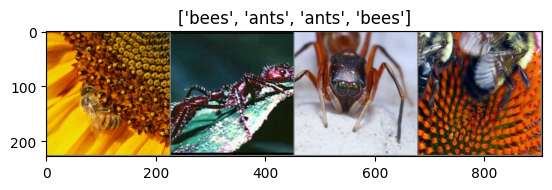

In [6]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.
model = models.resnet18(weights=True)
num_ftrs = model.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

In [10]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6561 Acc: 0.6148
val Loss: 0.4848 Acc: 0.8627

Epoch 1/24
----------
train Loss: 0.5435 Acc: 0.7377
val Loss: 0.3806 Acc: 0.8301

Epoch 2/24
----------
train Loss: 0.4968 Acc: 0.7459
val Loss: 0.3084 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4276 Acc: 0.8279
val Loss: 0.2815 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.4509 Acc: 0.7869
val Loss: 0.2426 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.4329 Acc: 0.7951
val Loss: 0.2373 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.3865 Acc: 0.8443
val Loss: 0.2329 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3708 Acc: 0.8238
val Loss: 0.2501 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3658 Acc: 0.8279
val Loss: 0.2243 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3967 Acc: 0.8074
val Loss: 0.2237 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.4101 Acc: 0.8074
val Loss: 0.2258 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3384 Acc: 0.8689
val Loss: 0.2350 Acc: 0.9281

Ep

In [12]:
#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(weights=True)
for param in model_conv.parameters():
    param.requires_grad = False

In [13]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(
    model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25
)

Epoch 0/24
----------
train Loss: 0.5529 Acc: 0.6721
val Loss: 0.4041 Acc: 0.8105

Epoch 1/24
----------
train Loss: 0.6287 Acc: 0.7254
val Loss: 0.2471 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.4744 Acc: 0.7664
val Loss: 0.2050 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.4352 Acc: 0.7828
val Loss: 0.1935 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4537 Acc: 0.7869
val Loss: 0.1925 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.5627 Acc: 0.7828
val Loss: 0.2123 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.4630 Acc: 0.7951
val Loss: 0.3648 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.3848 Acc: 0.8279
val Loss: 0.2178 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.4059 Acc: 0.8156
val Loss: 0.2640 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3763 Acc: 0.8156
val Loss: 0.2059 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.4009 Acc: 0.8402
val Loss: 0.2016 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3841 Acc: 0.8156
val Loss: 0.2277 Acc: 0.9412

Ep